In [1]:
!kaggle datasets download vipoooool/new-plant-diseases-dataset

/bin/bash: line 1: kaggle: command not found


In [2]:
import os
import glob
import keras
import tensorflow as tf
import numpy as np
from binary_train_and_eval import gen_dataset

In [3]:
keras.config.enable_unsafe_deserialization()

In [4]:
MODEL_DIR = "out"
model_files = [file for file in glob.glob(os.path.join(MODEL_DIR, "*_rgb.keras"))]
#model_files = [max(glob.glob(os.path.join("checkpoints", model_dir, "*")), key=os.path.getctime) for model_dir in os.listdir("checkpoints") if model_dir.endswith("_rgb")]
print(model_files)
TEST_DATA_PATH = os.path.join("_data", "combined", "test")
INPUT_SHAPE = (224, 224, 3)

['out/bestInceptionV3_rgb.keras', 'out/bestVisionTransformer_rgb.keras', 'out/bestAlexNet_rgb.keras', 'out/bestLeNet_rgb.keras', 'out/bestResNet152V2_rgb.keras', 'out/bestMobileNetV3Large_rgb.keras', 'out/bestVGG19_rgb.keras', 'out/bestConvNeXtLarge_rgb.keras']


In [5]:
models = {file.split("/")[-1].replace('best', '').replace('_rgb.keras', ''): keras.saving.load_model(file) for file in model_files}

2024-11-16 13:13:28.146449: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38484 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:41:00.0, compute capability: 8.0


In [6]:
print(models.keys())

dict_keys(['InceptionV3', 'VisionTransformer', 'AlexNet', 'LeNet', 'ResNet152V2', 'MobileNetV3Large', 'VGG19', 'ConvNeXtLarge'])


In [7]:
test_dataset = gen_dataset(TEST_DATA_PATH, batch_size=8, lab=False, input_shape=INPUT_SHAPE, aug=False, deterministic=True)

Found 9202 files belonging to 2 classes.


In [8]:
test_dataset = keras.utils.image_dataset_from_directory(TEST_DATA_PATH, 
                                                        batch_size=8, 
                                                        image_size=INPUT_SHAPE[:2], 
                                                        crop_to_aspect_ratio=True, 
                                                        labels="inferred", 
                                                        label_mode="binary",
                                                        shuffle=False)
test_dataset = test_dataset.map(lambda x, y: (x, tf.keras.utils.to_categorical(y, num_classes=2)))

Found 9202 files belonging to 2 classes.


In [9]:
y_trues = tf.concat(list(test_dataset.map(lambda x,y: y)), axis=0)

2024-11-16 13:14:50.744408: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [10]:
def reduce_y(y):
    return np.argmax(y, axis=1)

In [35]:
total = len(y_trues)
unique, counts = np.unique(reduce_y(y_trues), return_counts=True)
label_weights = 1 - (counts / total)

In [36]:
label_weights

array([0.31916975, 0.68083025])

In [37]:
preds = dict()
results = dict()

In [38]:
metrics=[
    keras.metrics.BinaryAccuracy(),
    tf.keras.metrics.Recall(),
    tf.keras.metrics.AUC(label_weights=label_weights),
    tf.keras.metrics.F1Score(),
]

In [39]:
for name, model in models.items():
    print(f"Evaluating {name}")
    result = {}
    
    y_preds = model.predict(test_dataset.map(lambda x,y: x))
    
    for metric in metrics:
        result[metric.name] = metric(y_trues, y_preds).numpy()
        
    print(result)
    
    results[name] = result
    preds[name] = {
        'y_true': y_trues,
        'y_pred': y_preds
    }

Evaluating InceptionV3
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 57s 50ms/step
{'binary_accuracy': 0.80797654, 'recall_1': 0.80797654, 'auc_1': 0.89412916, 'f1_score': array([0.8376068 , 0.76512027], dtype=float32)}
Evaluating VisionTransformer
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 57s 49ms/step
{'binary_accuracy': 0.6447783, 'recall_1': 0.6531732, 'auc_1': 0.7720177, 'f1_score': array([0.65049267, 0.6401632 ], dtype=float32)}
Evaluating AlexNet
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 54s 47ms/step
{'binary_accuracy': 0.7291712, 'recall_1': 0.7347678, 'auc_1': 0.8557697, 'f1_score': array([0.75512534, 0.6981032 ], dtype=float32)}
Evaluating LeNet
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step
{'binary_accuracy': 0.71708596, 'recall_1': 0.72128344, 'auc_1': 0.82135797, 'f1_score': array([0.7736333, 0.6239878], dtype=float32)}
Evaluating ResNet152V2
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 59s 51ms/step
{'binary_accuracy': 0.74074113, 'recall_1': 0.7440991, 'auc_1': 0.842197, 'f1_score': array([0.7976911, 0.6401328], dtype=fl

In [40]:
results

{'InceptionV3': {'binary_accuracy': 0.80797654,
  'recall_1': 0.80797654,
  'auc_1': 0.89412916,
  'f1_score': array([0.8376068 , 0.76512027], dtype=float32)},
 'VisionTransformer': {'binary_accuracy': 0.6447783,
  'recall_1': 0.6531732,
  'auc_1': 0.7720177,
  'f1_score': array([0.65049267, 0.6401632 ], dtype=float32)},
 'AlexNet': {'binary_accuracy': 0.7291712,
  'recall_1': 0.7347678,
  'auc_1': 0.8557697,
  'f1_score': array([0.75512534, 0.6981032 ], dtype=float32)},
 'LeNet': {'binary_accuracy': 0.71708596,
  'recall_1': 0.72128344,
  'auc_1': 0.82135797,
  'f1_score': array([0.7736333, 0.6239878], dtype=float32)},
 'ResNet152V2': {'binary_accuracy': 0.74074113,
  'recall_1': 0.7440991,
  'auc_1': 0.842197,
  'f1_score': array([0.7976911, 0.6401328], dtype=float32)},
 'MobileNetV3Large': {'binary_accuracy': 0.730756,
  'recall_1': 0.7335543,
  'auc_1': 0.82331467,
  'f1_score': array([0.8002742 , 0.58798397], dtype=float32)},
 'VGG19': {'binary_accuracy': 0.7460723,
  'recall_1': 

In [41]:
#results = {name: {key: value.numpy() for key, value in data.items() } for name, data in results.items()}

In [42]:
import pickle
with open(os.path.join("out", "result.pkl"), "wb+") as file:
    pickle.dump(results, file, protocol=pickle.HIGHEST_PROTOCOL)

In [43]:
results_data = [{**{'name': name}, **data, 'f1_score': data['f1_score'][0]} for name, data in results.items()]

In [44]:
import pandas as pd
df = pd.DataFrame(results_data)

In [45]:
df

,name,binary_accuracy,recall_1,auc_1,f1_score
0,InceptionV3,0.807977,0.807977,0.894129,0.837607
1,VisionTransformer,0.644778,0.653173,0.772018,0.650493
2,AlexNet,0.729171,0.734768,0.855770,0.755125
3,LeNet,0.717086,0.721283,0.821358,0.773633
4,ResNet152V2,0.740741,0.744099,0.842197,0.797691
5,MobileNetV3Large,0.730756,0.733554,0.823315,0.800274
6,VGG19,0.746072,0.748471,0.842135,0.809385
7,ConvNeXtLarge,0.735757,0.737856,0.830750,0.797276


In [46]:
df.set_index('name')
df.loc["Sum"] = df.sum(numeric_only=True)

df.to_latex(float_format="%.4f")

'\\begin{tabular}{llrrrr}\n\\toprule\n & name & binary_accuracy & recall_1 & auc_1 & f1_score \\\\\n\\midrule\n0 & InceptionV3 & 0.8080 & 0.8080 & 0.8941 & 0.8376 \\\\\n1 & VisionTransformer & 0.6448 & 0.6532 & 0.7720 & 0.6505 \\\\\n2 & AlexNet & 0.7292 & 0.7348 & 0.8558 & 0.7551 \\\\\n3 & LeNet & 0.7171 & 0.7213 & 0.8214 & 0.7736 \\\\\n4 & ResNet152V2 & 0.7407 & 0.7441 & 0.8422 & 0.7977 \\\\\n5 & MobileNetV3Large & 0.7308 & 0.7336 & 0.8233 & 0.8003 \\\\\n6 & VGG19 & 0.7461 & 0.7485 & 0.8421 & 0.8094 \\\\\n7 & ConvNeXtLarge & 0.7358 & 0.7379 & 0.8307 & 0.7973 \\\\\nSum & NaN & 5.8523 & 5.8812 & 6.6817 & 6.2215 \\\\\n\\bottomrule\n\\end{tabular}\n'

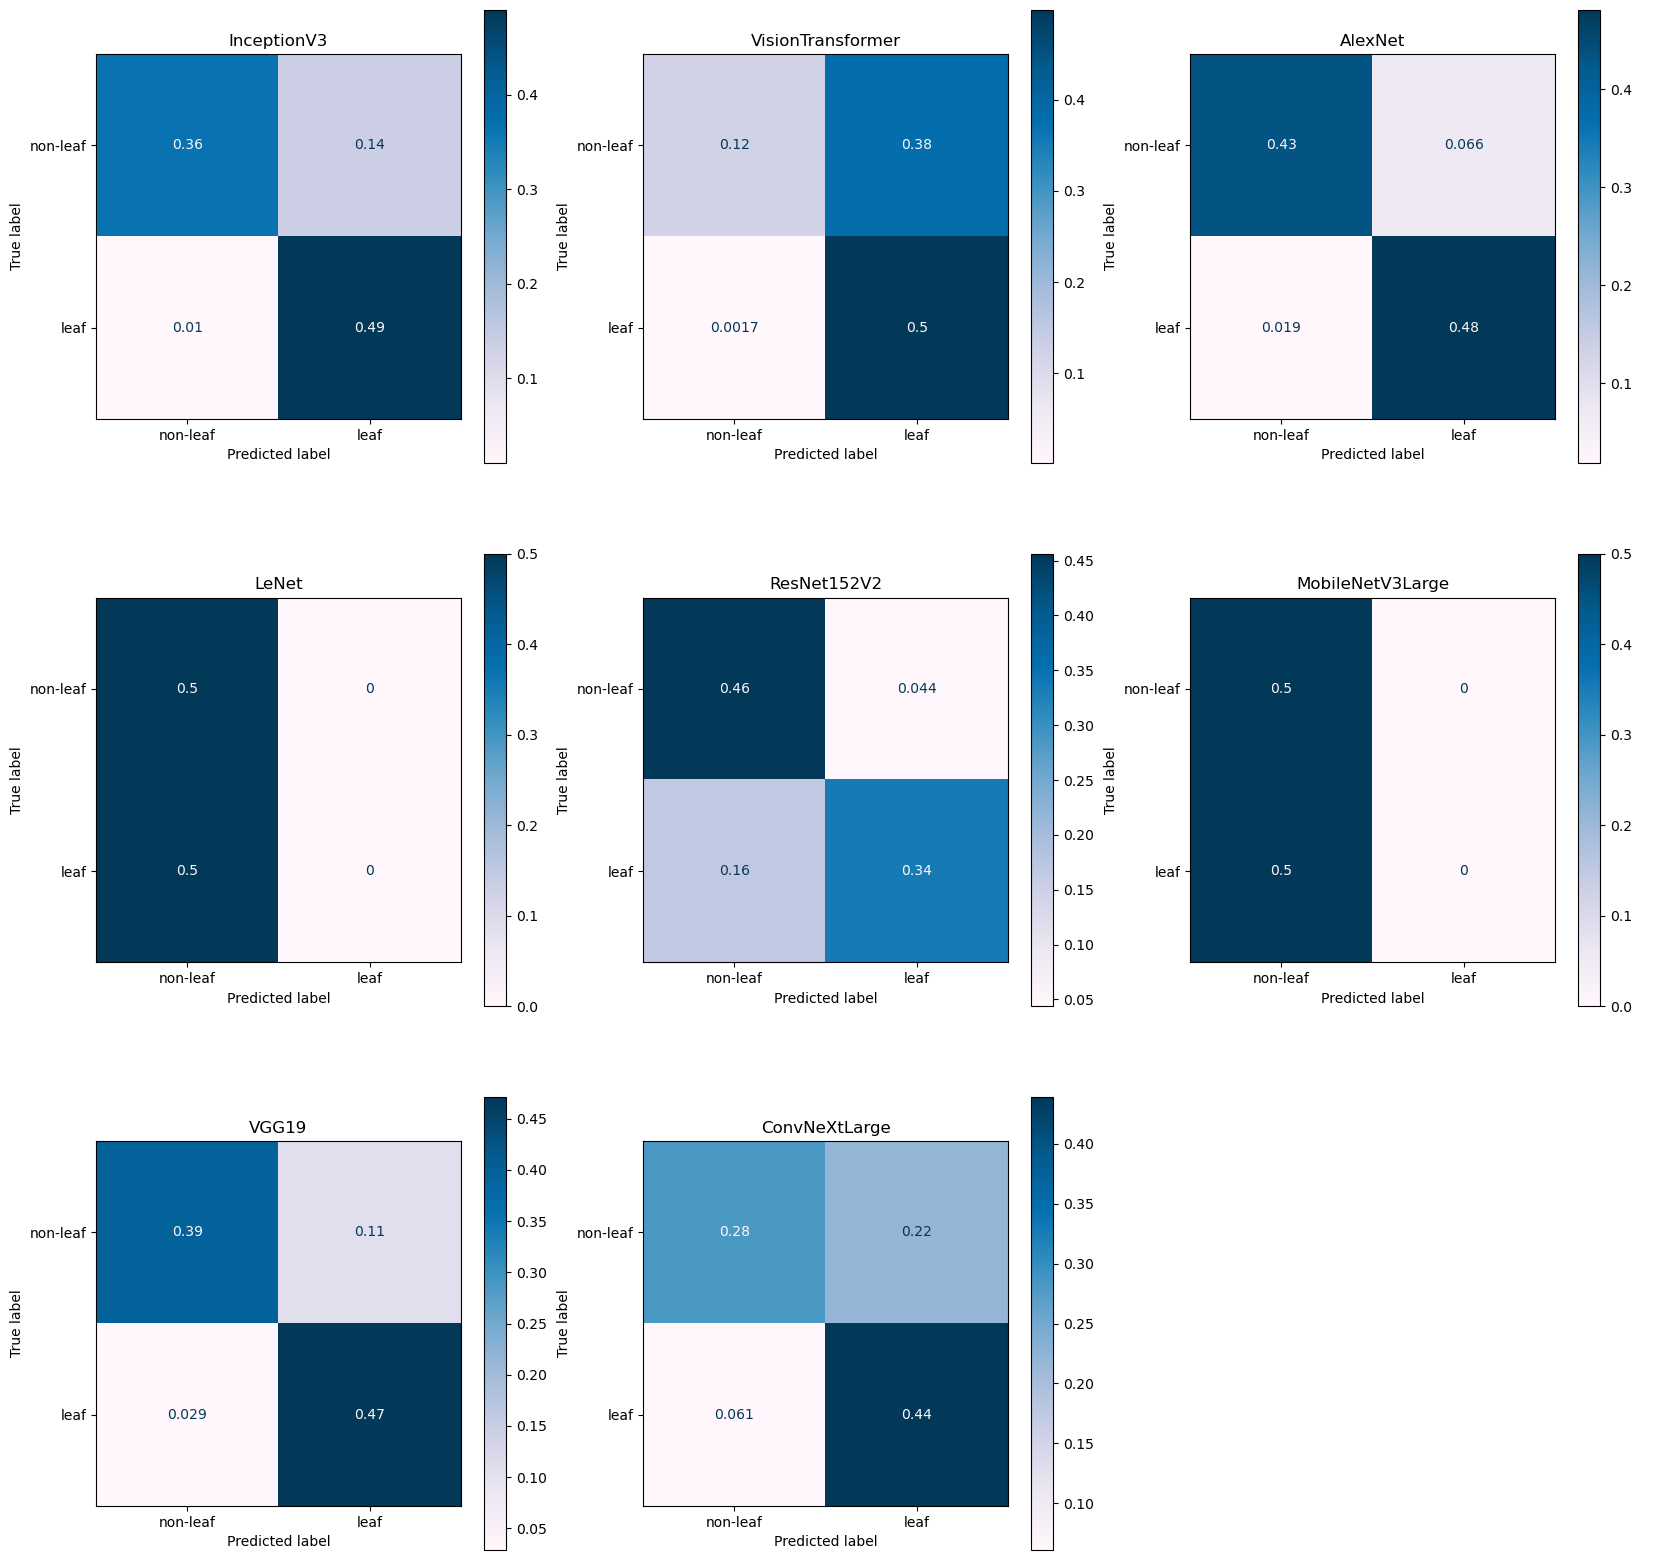

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
axes = axes.flatten()
axes[-1].axis('off')

for ax, (name, data) in zip(axes, preds.items()):
    sample_weight = np.array([label_weights[label] for label in reduce_y(y_trues)])
    disp = ConfusionMatrixDisplay.from_predictions(reduce_y(data['y_true']), reduce_y(data['y_pred']),
                                                   cmap="PuBu", 
                                                   ax=ax, 
                                                   normalize='all', 
                                                   display_labels=["diseased", 'healthy'],
                                                   sample_weight=sample_weight)
    disp.ax_.set_title(name)
plt.show()

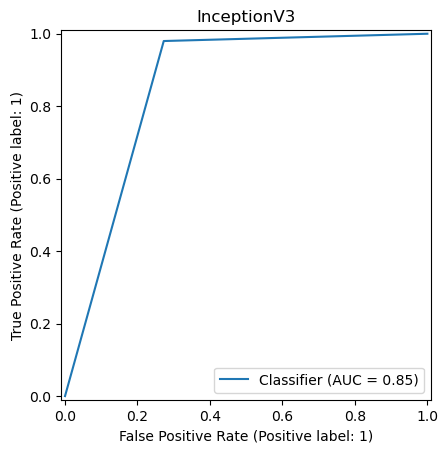

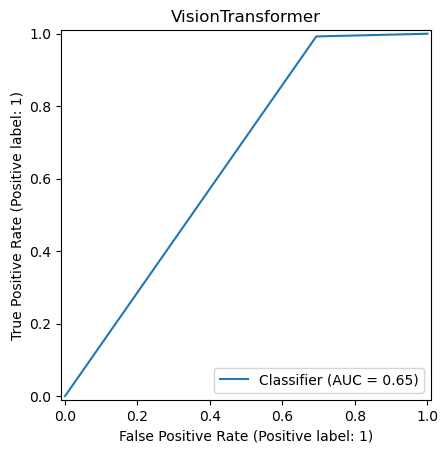

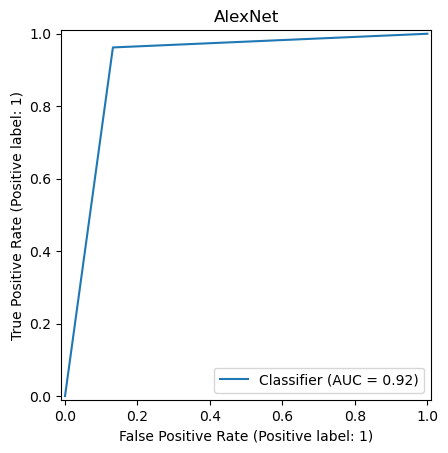

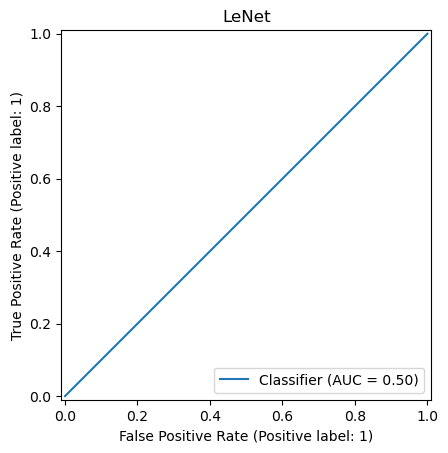

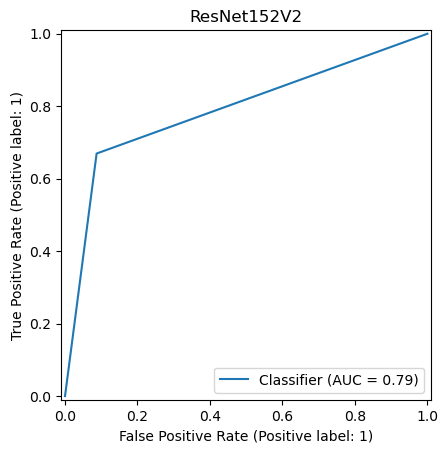

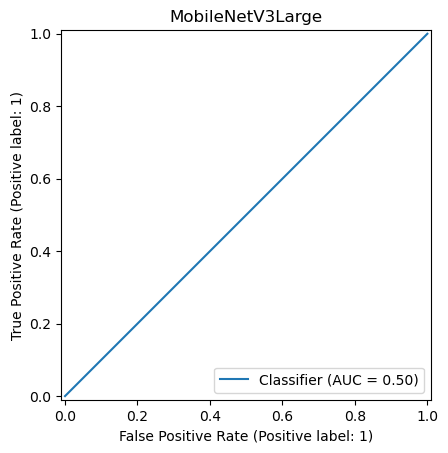

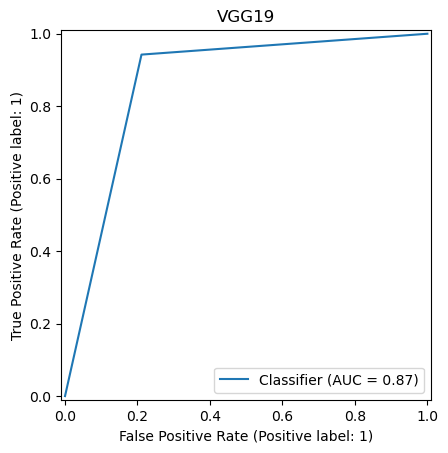

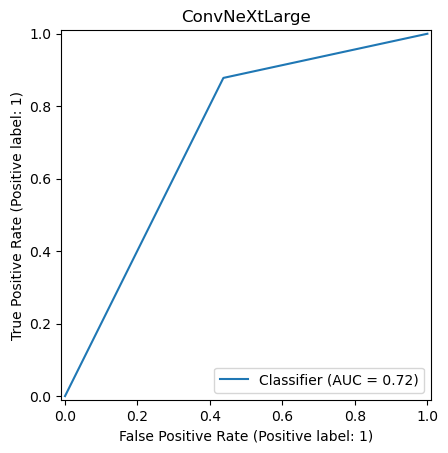

In [65]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
for name, data in preds.items():
    disp = RocCurveDisplay.from_predictions(reduce_y(data['y_true']), reduce_y(data['y_pred']))
    disp.ax_.set_title(name)
plt.show()

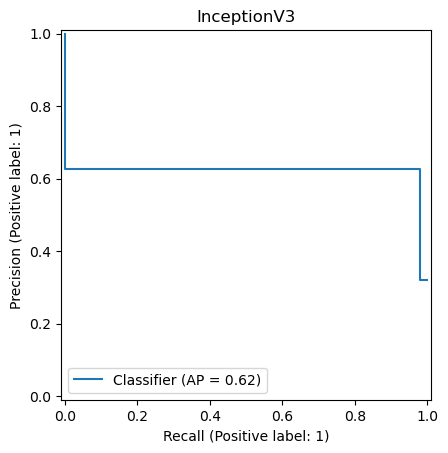

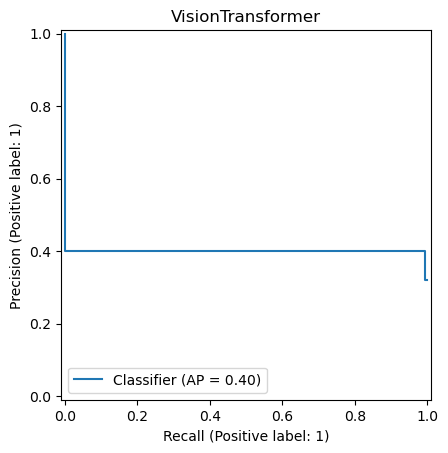

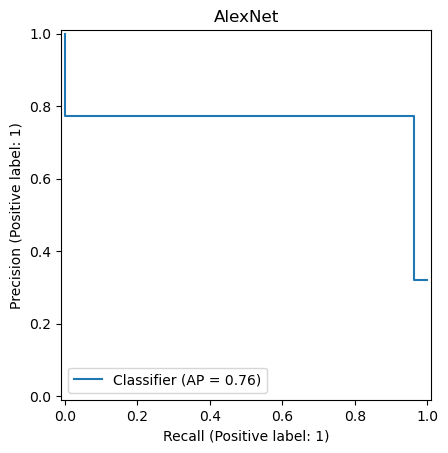

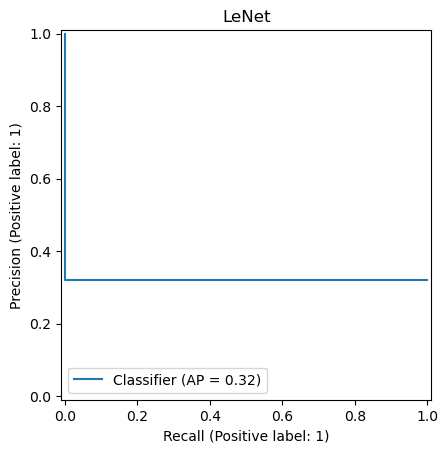

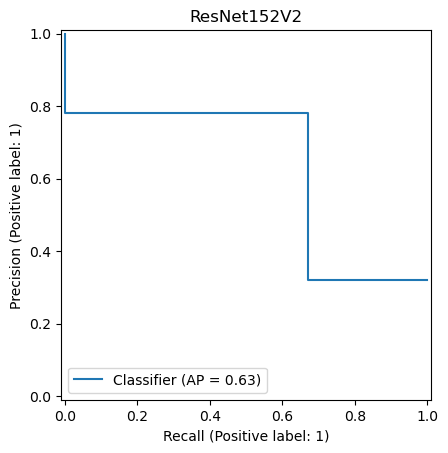

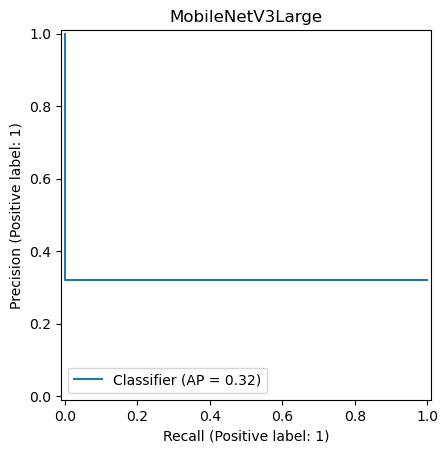

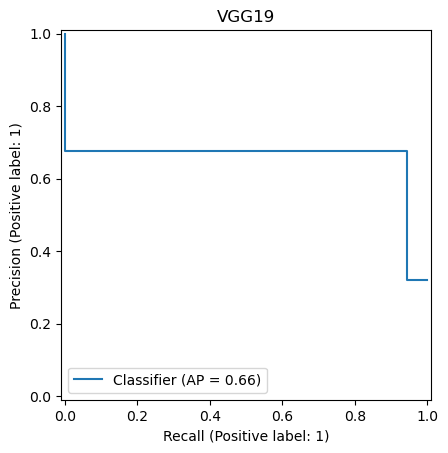

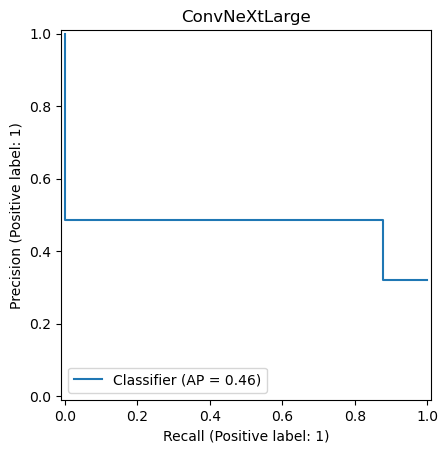

In [67]:
from sklearn.metrics import PrecisionRecallDisplay
import matplotlib.pyplot as plt
for name, data in preds.items():
    disp = PrecisionRecallDisplay.from_predictions(reduce_y(data['y_true']), reduce_y(data['y_pred']))
    disp.ax_.set_title(name)
plt.show()